# Purpose of the Analysis
The goal of this analysis is to measure the differential elastic cross section $dσ / dt$ for proton-proton scattering at the LHC using the TOTEM experiment. This requires precise reconstruction of the scattering angles and positions of elastically scattered protons, enabling extraction of physics observables such as:
* the four-momentum transfer squared $|t|$,
* the total and elastic cross sections,
* and comparison with theoretical models.

# Basic Data Properties and Elastic Event Selection

The first step focuses on understanding the geometry and hit distributions in the Roman Pot (RP) detectors. It includes:
* Loading raw detector data (hit positions, tracking validity, angles).
* Separating left/right and near/far stations.
* Visualizing 2D hit maps to identify active detector regions.
* Comparing RP units to ensure alignment and consistency.
* Preparing cleaned data for angle reconstruction by removing invalid or undefined values.

## Data File Loading

In [4]:
import ROOT 
from pathlib import Path

In [6]:
ROOT.EnableImplicitMT() #enable multiple cores for fast processing 

totem_ntuple = ROOT.ROOT.RDataFrame("TotemNtuple", "prepared_data.root")
totem_ntuple.Describe()

Dataframe from TChain TotemNtuple in file prepared_data.root

Property                Value
--------                -----
Columns in total           54
Columns from defines        0
Event loops run             0
Processing slots           10

Column                  Type            Origin
------                  ----            ------
bunch_num               UInt_t          Dataset
dataset_num             Int_t           Dataset
event_num               UInt_t          Dataset
input_status_bits       UInt_t          Dataset
run_no                  UInt_t          Dataset
t                       Double_t        Dataset
th                      Double_t        Dataset
th_x                    Double_t        Dataset
th_x_L                  Double_t        Dataset
th_x_R                  Double_t        Dataset
th_y                    Double_t        Dataset
th_y_L                  Double_t        Dataset
th_y_R                  Double_t        Dataset
timestamp               UInt_t         

## Roman Pot Detectors

In elastic proton-proton scattering, protons are scattered at very small angles after the collision. To reconstruct their trajectories, we need to detect their precise positions far from the interaction point. This is done using Roman Pots (RPs), which contain silicon strip detectors.
- RPs are movable beam-pipe insertions that allow very close positioning of detectors near the proton beam without interfering with its operation. Each RP is equipped with a stack of 10 silicon strip detectors that provide the x and y coordinates of the proton's hit point.

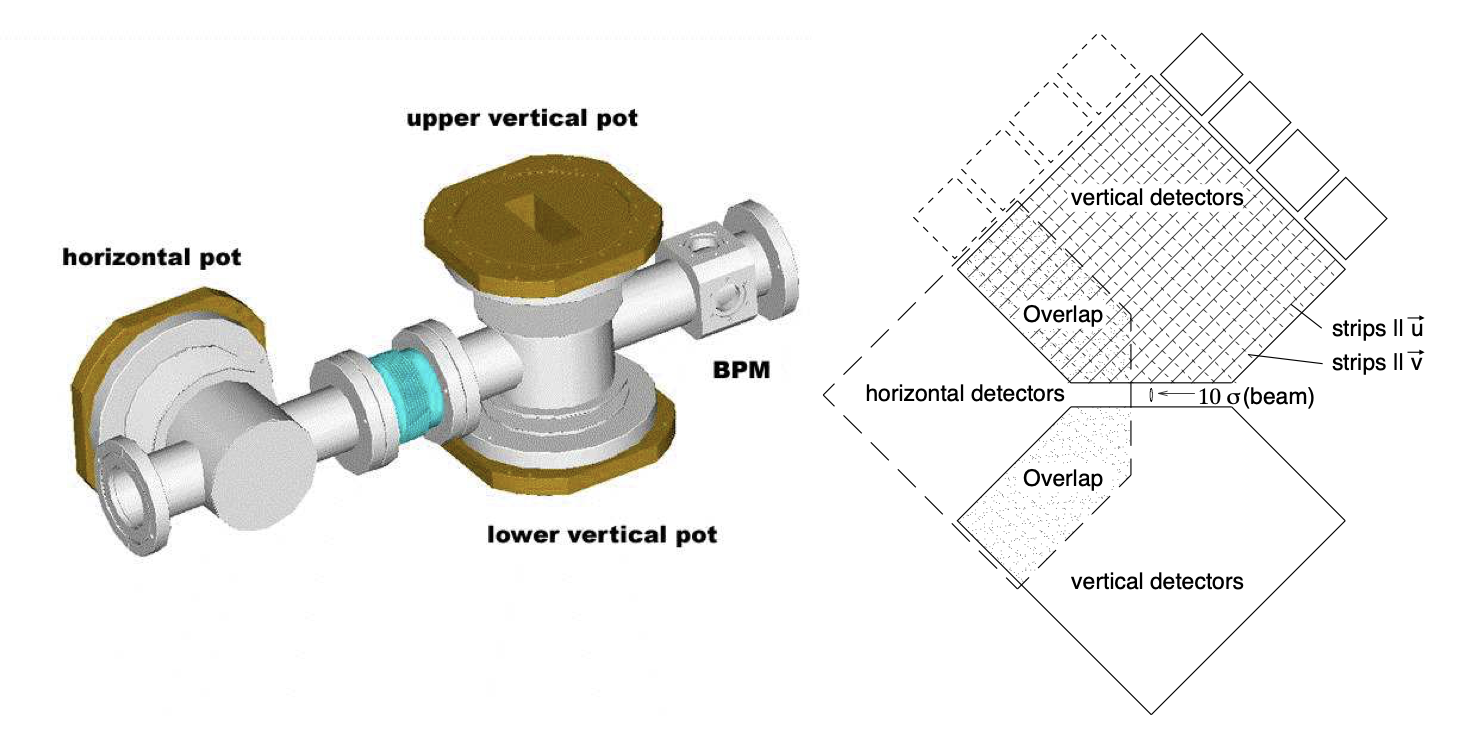

**Figure 1.**  Roman Pot Unit and silicon strips in one of the RP. The "u" strips are tilted at an angle of +45° and "v" strips at an angle -45° with respect to the detector edge facing the beam.[[1]](https://jinst.sissa.it/LHC/TOTEM/ch04.pdf)
 



The RPs are placed symmetrically on either side of the Interaction Point 5 (IP5) where the CMS detector is. There are four RP stations (each of them made of two units which contain three RPs- two placed vertically and one horizontally): two that are 150m away from IP5 and another two 220m away. In the analysis only stations 02 and 12 were utilized [[2]](https://iopscience.iop.org/article/10.1209/0295-5075/96/21002).   

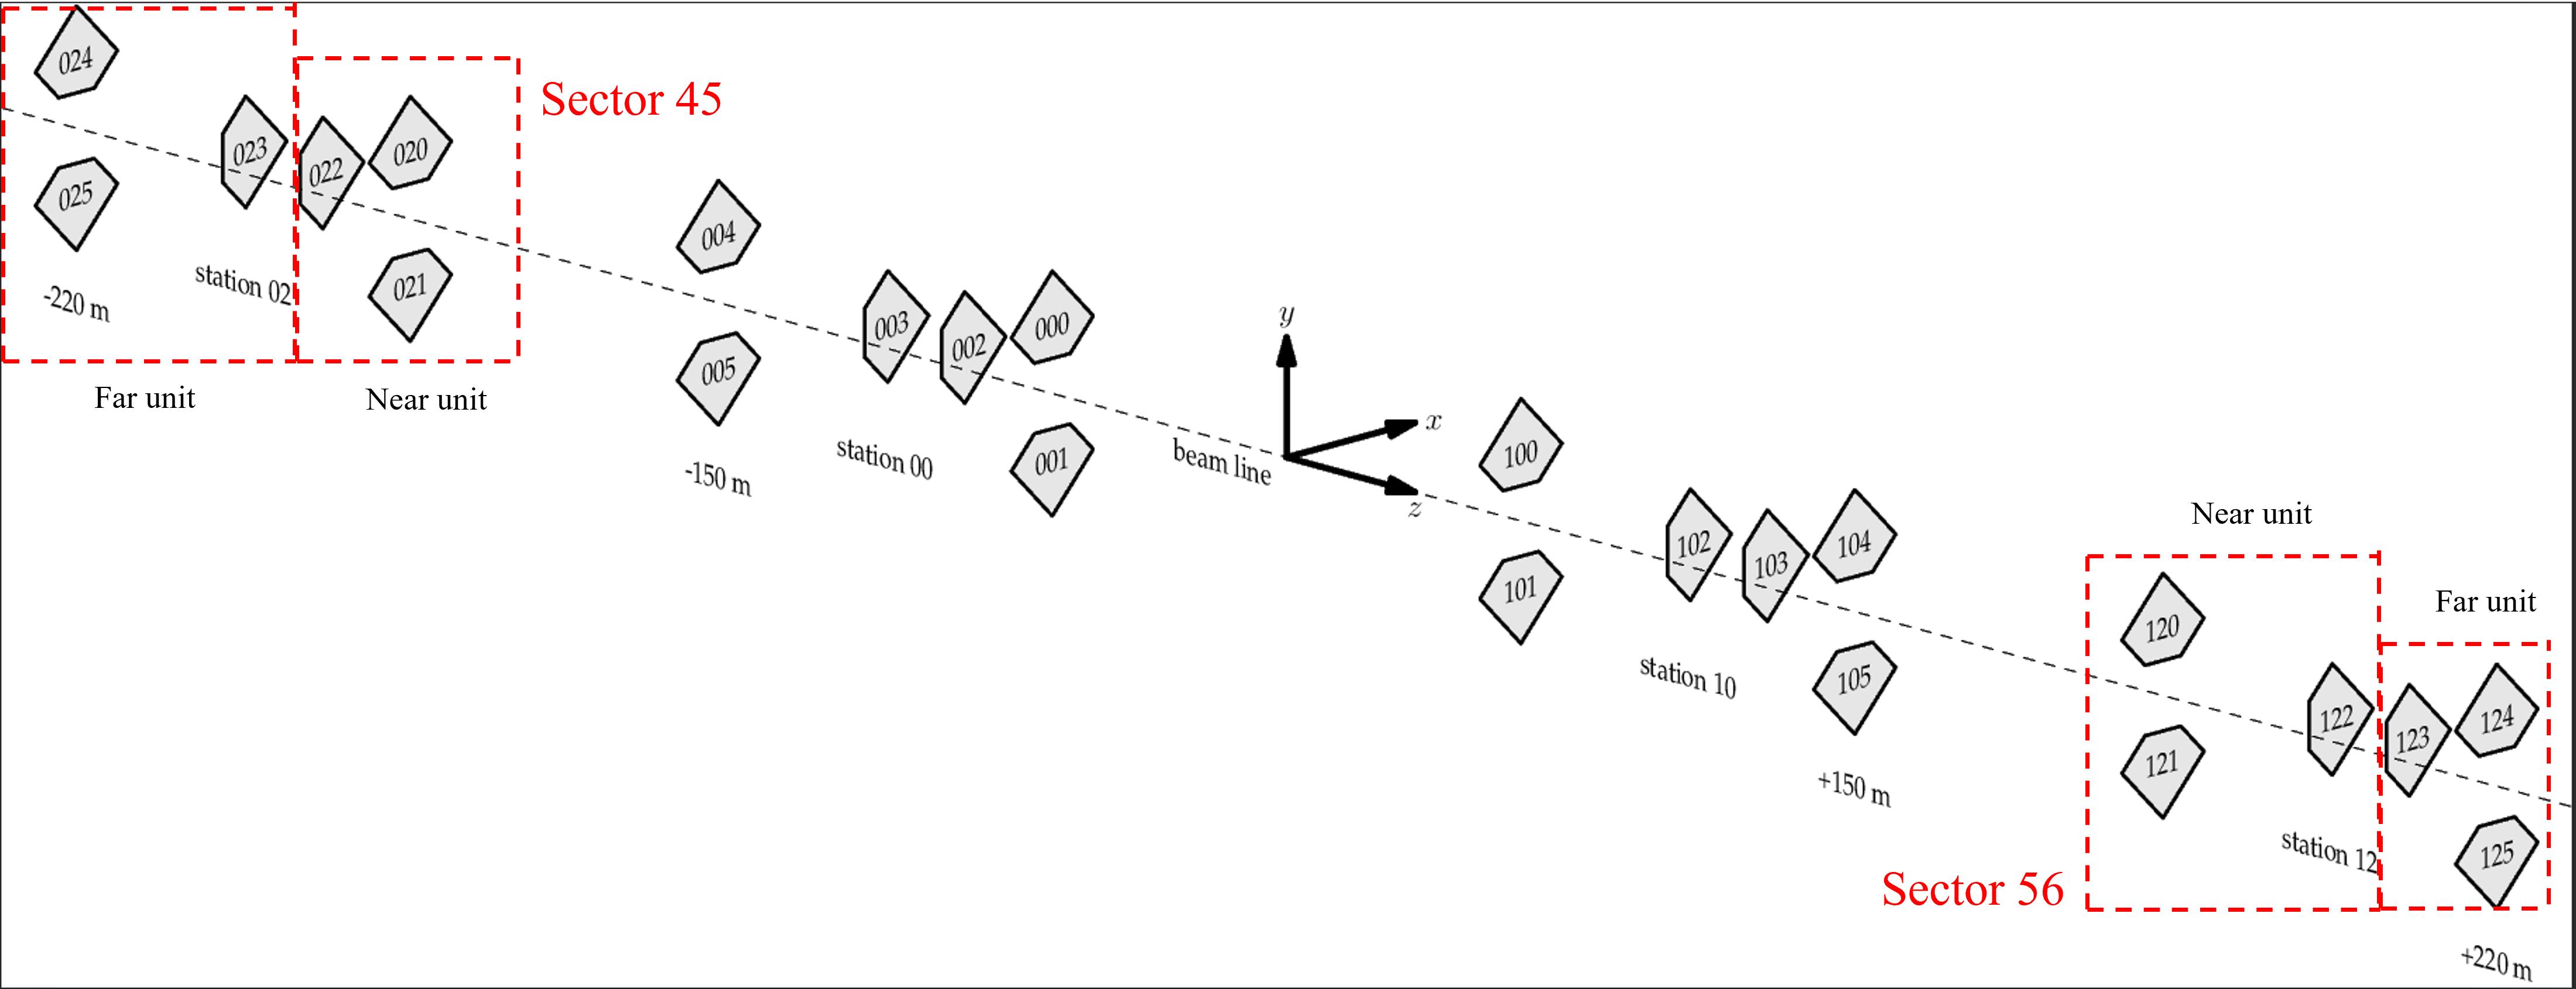
**Figure 2.** Configuration of the RPs with the IP5 in the center. The detectors used in this analysis are marked with red dashed boxes. Each RP is depicted as a pentagon and has unique 3-digit number. The boxes on the left are in sector 45 of the LHC, while those on the right are in sector 56.

* In the dataset each RP number corresponds to a group of columns in the ntuple, for example x coordinate of the hit in the left far station with number 024 is stored in a column named `track_rp_24_x`.

## Data Inspection

### Dataset Description

Roman Pots provide information where a proton hit the silicon sensors, which is later used to reconstruct interaction vertex x coordinate and the scattering angle $\theta^{*}$. The original values are from RPs are explained in the table below.

| Column Name            | Description                                                                 | Unit       |
|------------------------|-----------------------------------------------------------------------------|------------|
| `bunch_num`            | Bunch number indicating which proton bunch the event came from              | —          |
| `dataset_num`          | Identifier for the dataset number (e.g., 1, 2, 3)                           | —          |
| `event_num`            | Unique event identifier                                                     | —          |
| `input_status_bits`    | Result of the trigger logic where each bit corresponds to one entry in the trigger menu | —          |
| `run_no`               | Run number                                                                  | —          |
| `t`                    | Mandelstam variable: squared four-momentum transfer                         | GeV²       |
| `th`                   | Magnitude of the scattering angle √(th_x² + th_y²)                          | rad        |
| `th_x`                 | Scattering angle in the x-direction                                         | rad        |
| `th_x_L`               | Scattering angle in x from left                                             | rad        |
| `th_x_R`               | Scattering angle in x from right                                            | rad        |
| `th_y`                 | Scattering angle in the y-direction                                         | rad        |
| `th_y_L`               | Scattering angle in y from left                                             | rad        |
| `th_y_R`               | Scattering angle in y from right                                            | rad        |
| `timestamp`            | Time stamp of the event                                                     | —          |
| `track_rp_XXX_valid`   | Whether a valid track hit exists in RP XXX                                  | -          |
| `track_rp_XXX_x`       | Registered x position in the RP XXX                                         | mm         |
| `track_rp_XXX_y`       | Registered y position in the RP XXX                                         | mm         |
| `trigger_num`          | Trigger number for the event                                                | —          |
| `vtx_x`                | Reconstructed interaction vertex x-position                                 | mm         |
| `vtx_x_L`              | Vertex x-position reconstructed from left                                   | mm         |
| `vtx_x_R`              | Vertex x-position reconstructed from right                                  | mm         |

**Table 1.** Variables obtained from the RPs.

### Visualization of the Data

**-> Now we will select valid hits from RP stations and create 2D histograms of x and y hit coordinates.**

At below:
- Histo2D(("name", "title", bins_x, min_x, max_x, bins_y, min_y, max_y), "x_var", "y_var")
- Filter the data to ensure only valid hits are used.
- Create 2D histograms (TH2D) for each tracking station (RPs).
- Merge them into a single histogram.

In [7]:
def left_far_station_histogram(dataset: ROOT.RDataFrame, label: str="") -> ROOT.TH2D:
    rp_023_histogram = dataset.Filter("track_rp_23_valid").Histo2D(("RP_023", "RP_023", 256, -30, 30, 256, -30, 30), "track_rp_23_x", "track_rp_23_y")
    rp_024_histogram = dataset.Filter("track_rp_24_valid").Histo2D(("RP_024", "RP_024", 256, -30, 30, 256, -30, 30), "track_rp_24_x", "track_rp_24_y")
    rp_025_histogram = dataset.Filter("track_rp_25_valid").Histo2D(("RP_025", "RP_025", 256, -30, 30, 256, -30, 30), "track_rp_25_x", "track_rp_25_y")
    rp_023_024_025_histogram = rp_023_histogram.GetValue().Clone(f"{label} Left far unit hits")
    rp_023_024_025_histogram.Add(rp_024_histogram.GetValue())
    rp_023_024_025_histogram.Add(rp_025_histogram.GetValue())
    rp_023_024_025_histogram.SetTitle(f"{label} Left far unit hits; x[mm]; y[mm]")
    return rp_023_024_025_histogram

In [8]:
def left_near_station_histogram(dataset: ROOT.RDataFrame, label: str="") -> ROOT.TH2D:
    rp_020_histogram = dataset.Filter("track_rp_20_valid").Histo2D(("RP_020", "RP_020", 256, -30, 30, 256, -30, 30), "track_rp_20_x", "track_rp_20_y")
    rp_021_histogram = dataset.Filter("track_rp_21_valid").Histo2D(("RP_021", "RP_021", 256, -30, 30, 256, -30, 30), "track_rp_21_x", "track_rp_21_y")
    rp_022_histogram = dataset.Filter("track_rp_22_valid").Histo2D(("RP_022", "RP_022", 256, -30, 30, 256, -30, 30), "track_rp_22_x", "track_rp_22_y")
    rp_020_021_022_histogram = rp_020_histogram.GetValue().Clone(f"Dataset {label} Left near unit hits")
    rp_020_021_022_histogram.Add(rp_021_histogram.GetValue())
    rp_020_021_022_histogram.Add(rp_022_histogram.GetValue())
    rp_020_021_022_histogram.SetTitle(f"{label} Left near unit hits; x[mm]; y[mm]")
    return rp_020_021_022_histogram

In [9]:
def right_near_station_histogram(dataset: ROOT.RDataFrame, label: str="") -> ROOT.TH2D:
    rp_120_histogram = dataset.Filter("track_rp_120_valid").Histo2D(("RP_120", "RP_120", 256, -30, 30, 256, -30, 30), "track_rp_120_x", "track_rp_120_y")
    rp_121_histogram = dataset.Filter("track_rp_121_valid").Histo2D(("RP_121", "RP_121", 256, -30, 30, 256, -30, 30), "track_rp_121_x", "track_rp_121_y")
    rp_122_histogram = dataset.Filter("track_rp_122_valid").Histo2D(("RP_122", "RP_122", 256, -30, 30, 256, -30, 30), "track_rp_122_x", "track_rp_122_y")
    rp_120_121_122_histogram = rp_120_histogram.GetValue().Clone(f"Dataset {label} Right near unit hits")
    rp_120_121_122_histogram.Add(rp_121_histogram.GetValue())
    rp_120_121_122_histogram.Add(rp_122_histogram.GetValue())
    rp_120_121_122_histogram.SetTitle(f"{label} Right near unit hits; x[mm]; y[mm]")
    return rp_120_121_122_histogram

In [10]:
def right_far_station_histogram(dataset: ROOT.RDataFrame, label: str="") -> ROOT.TH2D:
    rp_123_histogram = dataset.Filter("track_rp_123_valid").Histo2D(("RP_123", "RP_123", 256, -30, 30, 256, -30, 30), "track_rp_123_x", "track_rp_123_y")
    rp_124_histogram = dataset.Filter("track_rp_124_valid").Histo2D(("RP_124", "RP_124", 256, -30, 30, 256, -30, 30), "track_rp_124_x", "track_rp_124_y")
    rp_125_histogram = dataset.Filter("track_rp_125_valid").Histo2D(("RP_125", "RP_125", 256, -30, 30, 256, -30, 30), "track_rp_125_x", "track_rp_125_y")
    rp_123_124_125_histogram = rp_123_histogram.GetValue().Clone(f"Dataset {label} Right far unit hits")
    rp_123_124_125_histogram.Add(rp_124_histogram.GetValue())
    rp_123_124_125_histogram.Add(rp_125_histogram.GetValue())
    rp_123_124_125_histogram.SetTitle(f"{label} Right far unit hits; x[mm]; y[mm]")
    return rp_123_124_125_histogram

In [11]:
all_hits_canvas = ROOT.TCanvas("Roman Pots Hits", "Histograms", 1000, 1000)
all_hits_canvas.Divide(2, 2)

#set a hist variable, otherwise it doesn't work
all_hits_canvas.cd(1)
ROOT.gPad.SetGrid()
left_near_histogram = left_near_station_histogram(totem_ntuple, "Dataset 1 & 2 & 3")
left_near_histogram.Draw("colz")

all_hits_canvas.cd(2)
ROOT.gPad.SetGrid()
left_far_histogram = left_far_station_histogram(totem_ntuple, "Dataset 1 & 2 & 3")
left_far_histogram.Draw("colz")

all_hits_canvas.cd(3)
ROOT.gPad.SetGrid()
right_near_histogram = right_near_station_histogram(totem_ntuple, "Dataset 1 & 2 & 3")
right_near_histogram.Draw("colz")

all_hits_canvas.cd(4)
ROOT.gPad.SetGrid()
right_far_histogra = right_far_station_histogram(totem_ntuple, "Dataset 1 & 2 & 3")
right_far_histogra.Draw("colz")

all_hits_canvas.Draw()


**Figure 3.** Hit maps of potential elastic proton candidates from all datasets. The displayed hits are required to pass the trigger in one of three RPs. 
- Hits are generally concentrated at x ≈ 0 mm, many protons passed through with a small scattering angle.
- At far stations, there is a broader spread of hits, protons have traveled further and experienced slight angular deviations.

**-> As we can see in the histogram above, there is overlap between the detectors. therefore, we will separate and analyze the horizontal and vertical detector components individually to observe the overlap more clearly.**

In [12]:
sep_rp = ROOT.TCanvas("c", "Right Far RP Hits (023, 024, 025)", 1400, 600)
sep_rp.Divide(3, 1)

sep_rp.cd(1)
ROOT.gPad.SetGrid()
rp_1 = totem_ntuple.Filter("track_rp_23_valid").Histo2D(("RP_023", "RP 023 hits;x [mm];y [mm]", 256, -30, 30, 256, -30, 30),"track_rp_23_x", "track_rp_23_y")
rp_1.Draw("colz")

sep_rp.cd(2)
ROOT.gPad.SetGrid()
rp_2 = totem_ntuple.Filter("track_rp_24_valid").Histo2D(("RP_024", "RP 024 hits;x [mm];y [mm]", 256, -30, 30, 256, -30, 30),"track_rp_24_x", "track_rp_24_y")
rp_2.Draw("colz")

sep_rp.cd(3)
ROOT.gPad.SetGrid()
rp_3 = totem_ntuple.Filter("track_rp_25_valid").Histo2D(("RP_025", "RP 025 hits;x [mm];y [mm]", 256, -30, 30, 256, -30, 30),"track_rp_25_x", "track_rp_25_y")
rp_3.Draw("colz")

sep_rp.Draw()

**Figure 4.** Hit maps from each RP detectors

In [13]:
ROOT.gStyle.SetOptStat(0)

overlap = ROOT.TCanvas("overlap", "RP 023 vs RP 024 vs RP 025 Overlap", 600, 600)
overlap.SetGrid()

rp_023 = totem_ntuple.Filter("track_rp_23_valid").Histo2D(("RP_023", " "";x [mm];y [mm]", 256, -30, 30, 256, -30, 30),"track_rp_23_x", "track_rp_23_y")
rp_023.SetLineColor(ROOT.kBlue)

rp_024 = totem_ntuple.Filter("track_rp_24_valid").Histo2D(("RP_024", " "";x [mm];y [mm]", 256, -30, 30, 256, -30, 30),"track_rp_24_x", "track_rp_24_y")
rp_024.SetLineColor(ROOT.kRed)

rp_025 = totem_ntuple.Filter("track_rp_25_valid").Histo2D(("RP_025", " "";x [mm];y [mm]", 256, -30, 30, 256, -30, 30),"track_rp_25_x", "track_rp_25_y")
rp_025.SetLineColor(ROOT.kGreen)

rp_023.Draw("box")
rp_024.Draw("box same")
rp_025.Draw("box same")

overlap.Draw()

**Figure 5.** Overlapped hits.

## Properties of Datasets Included in the Analysis

The data analysis is based on three datasets, each corresponding to data taken with the silicon sensors positioned at various distances from the beam. Each dataset contains a different number of events and covers a different range of the four-momentum transfer squared, $|t|$. The features of each dataset are shown in Tab. 2, and an example of the detector's position relative to the beam is illustrated in Fig. 4. 


**-> A key parameter that determines how close the detectors can safely approach the beam is the beam size, denoted by $\sigma_{\text{beam}}$. It is given by:**

$$
\sigma_{\text{beam}} = \sqrt{\varepsilon \cdot \beta^*}
$$

- $ε$ is the transverse beam emittance (a measure of how spread out the particles are in position-momentum space),

- $β^*$ is the optical beta function at the interaction point (IP), which describes how the beam width evolves along the accelerator.

The parameter $β^*$ defines how focused or diverging the beam is at the IP. A larger β* results in a narrower beam with smaller divergence, which is beneficial for precise measurements of small scattering angles and hence small momentum transfers **∣t∣**. Originally the experiment was performed with 
$β^*$ = 90m,  which allowed the Roman Pot detectors to measure very small scattering angles with high precision. 


**Table 2.** Description of the three data sets available. The RP
position gives the RP approach to the beam in multiples of the
beam size ($\sigma_{beam}$). The third column summarizes the numbers
of elastic events reconstructed from both diagonals. $L_{int}$ is
the integrated luminosity for each data set, accounting for the
data acquisition (DAQ) inefficiency. The last column shows
the lowest $|t|$-values reached.

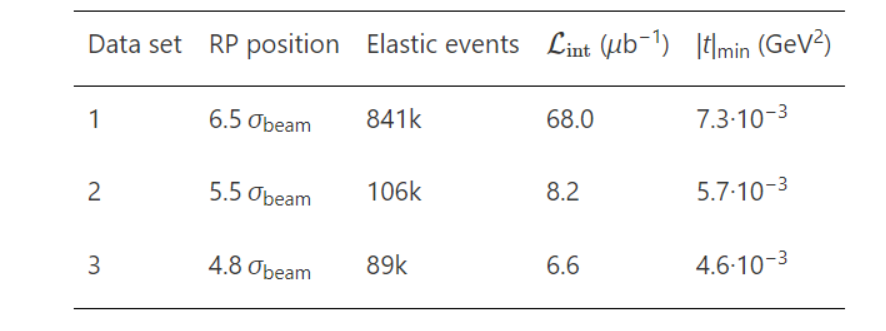

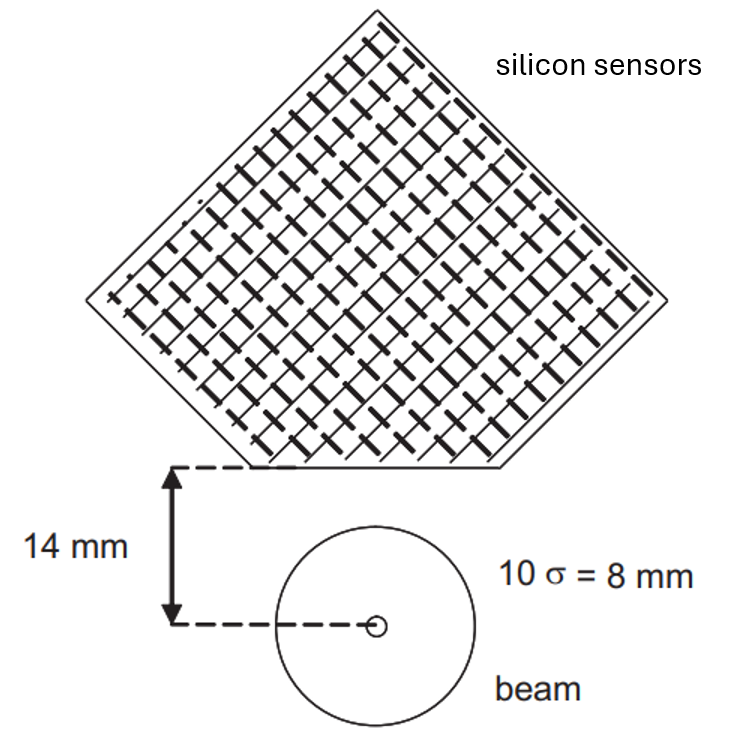

**Figure 6.** Silicon sensors positioned 14mm from the beam center.[[1]](https://jinst.sissa.it/LHC/TOTEM/ch04.pdf)

## Dataset Configuration

In [14]:
# dataset_1 = {"min": 6884, "max": 6929}
# dataset_2 = {"min": 6936, "max": 6943}  69400000   69430000
# dataset_3 = {"min": 6944, "max": 6947}


dataset1 = totem_ntuple.Filter("dataset_num == 1", "Dataset 1")\
                        .Filter("input_status_bits & 3", "RP trigger only")\
                        .Filter("bunch_num == 0", "Big bunch only")
#                        .Filter("run_no != 69300000 && run_no != 69400000 && run_no != 69430000", "Troublesome runs removed")\


dataset2 = totem_ntuple.Filter("dataset_num == 2", "Dataset 2")\
                        .Filter("input_status_bits & 3", "RP trigger only")\
                        .Filter("run_no != 69400000 && run_no != 69430000", "Troublesome runs removed")\
                        .Filter("bunch_num == 0", "Big bunch only")


dataset3 = totem_ntuple.Filter("dataset_num == 3", "Dataset 3")\
                        .Filter("input_status_bits & 3", "RP trigger only")\
                        .Filter("bunch_num == 0", "Big bunch only")
#                        .Filter("run_no != 69300000 && run_no != 69400000 && run_no != 69430000", "Troublesome runs removed")\

* **dataset_num == x:** select specific datasets from totem_ntuple.

* **input_status_bits & 3:** apply bitwise `And` operation. (checking last 2 bits) ensures that only RP triggered events are included.
   - 3 in binary = 11 -> This acts as a **mask** that selects only the **lowest two bits** of `input_status_bits`. When you perform `input_status_bits & 3`, all higher bits are ignored and only the last two are checked. For example:
   input_status_bits = 5 → 101 
   result = 101 & 011 = 001 = 1 → passes the filter
   input_status_bits = 4 → 100 
   result = 100 & 011 = 000 = 0 → does NOT pass


* **bunch_num == 0:** select the events from big proton bunch. remove low-intensity bunches, improve data quality.

* **run_no != x:** remove the problematic runs.


In [15]:
temp = totem_ntuple.Filter("dataset_num != -1", "Belongs to dataset 1 or 2 or 3")\
                    .Filter("input_status_bits & 3", "RP trigger only")\
                    .Filter("bunch_num == 0", "Big bunch only")

temp.Report().Print()

Belongs to dataset 1 or 2 or 3: pass=12183456   all=12606699   -- eff=96.64 % cumulative eff=96.64 %
RP trigger only: pass=1782345    all=12183456   -- eff=14.63 % cumulative eff=14.14 %
Big bunch only: pass=1588513    all=1782345    -- eff=89.12 % cumulative eff=12.60 %


* At LHC most collisions lead the particle production (jets, hadrons, etc.). only a small fraction of protons remain inside the beam and reach the RP detectors. so "RP trigger only" efficiency is very small.

## Filtering Valid Tracks in Diagonal Configuration
At the LHC, protons can scatter elastically:
- They remain intact but change trajectory slightly due to the interaction.
- Their new path depends on the LHC optics and detector placement.

The RP detectors are positioned above and below the beamline on both sides of the interaction point.
Due to the $β^*$ = 90m optics configuration, elastic protons are primarily scattered in the vertical direction, meaning:
Protons going left-downward should match protons going right-upward and protons going left-upward should match protons going right-downward. This results in two possible diagonals:

- 45 bottom – 56 top (45b56t)
the proton on beam 45 (left side) is detected in the bottom RP.
the proton on beam 56 (right side) is detected in the top RP.
- 45 top – 56 bottom (45t56b)
the proton on beam 45 (left side) is detected in the top RP.
the proton on beam 56 (right side) is detected in the bottom RP.

In 0.2% of cases, multiple proton pairs collide in the same event, producing elastic candidates in both diagonals simultaneously. this is negligiblew and not part of the main process.

The code below filters the data based on valid hits in the given RP configuration for all three datasets. Additionally, it selects only events that correspond to one of the diagonal configurations, identifying candidates for elastically scattered protons.

In [16]:
diag_45b56t_expression = "(track_rp_25_valid && track_rp_21_valid && track_rp_120_valid && track_rp_124_valid)"
diag_45t56b_expression = "(track_rp_24_valid && track_rp_20_valid && track_rp_121_valid && track_rp_125_valid)"

elastic_candidate_only_one_diagonal_valid = f"({diag_45b56t_expression} ^ {diag_45t56b_expression})"  # XOR to select one of diagonals

"""
XOR (eXclusive OR) truth table:
p  |  q  |  p ^ q 
0  |  0  |    0
0  |  1  |    1
1  |  0  |    1
1  |  1  |    0

"""

dataset1_diagonal = dataset1.Filter(elastic_candidate_only_one_diagonal_valid, "Elastic candidate diagonal selection")\
                            .Define("diagonal", diag_45b56t_expression) # 1 if diagonal 45b56t is valid, 0 if diagonal 45t56b is valid

dataset2_diagonal = dataset2.Filter(elastic_candidate_only_one_diagonal_valid, "Elastic candidate diagonal selection")\
                            .Define("diagonal", diag_45b56t_expression) # 1 if diagonal 45b56t is valid, 0 if diagonal 45t56b is valid

dataset3_diagonal = dataset3.Filter(elastic_candidate_only_one_diagonal_valid, "Elastic candidate diagonal selection")\
                            .Define("diagonal", diag_45b56t_expression) # 1 if diagonal 45b56t is valid, 0 if diagonal 45t56b is valid



- diagonal 45 bot to 56 top : proton detected in RP 25/21/120/124.
- diagonal 45 top to 56 bot : proton detected in RP 24/20/121/125.

if a proton undergoes an elastic scattering, it follows one of these trajectories, meaning only one diagonal should be valid (1,0 or 0,1).

In [17]:
dataset1_diagonal.Report().Print()

Dataset 1 : pass=9215831    all=12606699   -- eff=73.10 % cumulative eff=73.10 %
RP trigger only: pass=1278046    all=9215831    -- eff=13.87 % cumulative eff=10.14 %
Big bunch only: pass=1157375    all=1278046    -- eff=90.56 % cumulative eff=9.18 %
Elastic candidate diagonal selection: pass=918771     all=1157375    -- eff=79.38 % cumulative eff=7.29 %


In [18]:
dataset2_diagonal.Report().Print()

Dataset 2 : pass=1941282    all=12606699   -- eff=15.40 % cumulative eff=15.40 %
RP trigger only: pass=300523     all=1941282    -- eff=15.48 % cumulative eff=2.38 %
Troublesome runs removed: pass=295213     all=300523     -- eff=98.23 % cumulative eff=2.34 %
Big bunch only: pass=262973     all=295213     -- eff=89.08 % cumulative eff=2.09 %
Elastic candidate diagonal selection: pass=130941     all=262973     -- eff=49.79 % cumulative eff=1.04 %


In [19]:
dataset3_diagonal.Report().Print()

Dataset 3 : pass=1026343    all=12606699   -- eff=8.14 % cumulative eff=8.14 %
RP trigger only: pass=203776     all=1026343    -- eff=19.85 % cumulative eff=1.62 %
Big bunch only: pass=163416     all=203776     -- eff=80.19 % cumulative eff=1.30 %
Elastic candidate diagonal selection: pass=107041     all=163416     -- eff=65.50 % cumulative eff=0.85 %


**->To see the drops in efficiency:** 

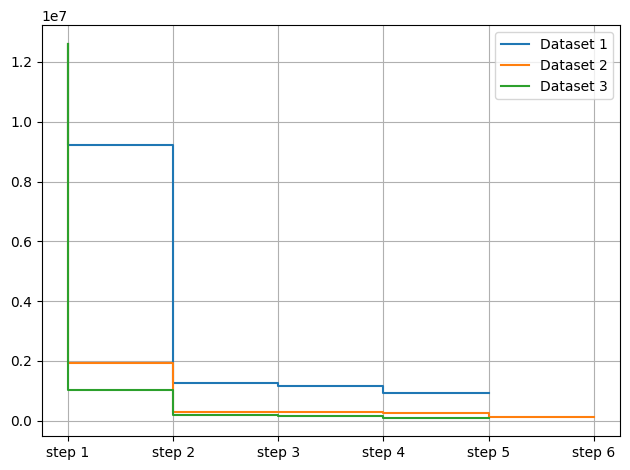

In [20]:
import matplotlib.pyplot as plt

initial_total = 12606699

dataset_counts = {
    "Dataset 1": [12606699, 9215831, 1278046, 1157375, 918771],
    "Dataset 2": [12606699, 1941282, 300523, 295213, 262973, 130941],
    "Dataset 3": [12606699, 1026343, 203776, 163416, 107041],}

steps_labels = {
    "Dataset 1": [
        "All Events",
        "dataset_num == 1",
        "RP trigger only",
        "Big bunch only",
        "Elastic diagonal"],
    "Dataset 2": [
        "All Events",
        "dataset_num == 2",
        "RP trigger only",
        "Run filter",
        "Big bunch only",
        "Elastic diagonal"],
    "Dataset 3": [
        "All Events",
        "dataset_num == 3",
        "RP trigger only",
        "Big bunch only",
        "Elastic diagonal"]}

for ds_name, counts in dataset_counts.items():
    plt.step(range(len(counts)), counts, label=ds_name)

max_steps = max(len(s) for s in steps_labels.values())
plt.xticks(
    range(max_steps),
    [f"step {i+1}" for i in range(max_steps)])

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Figure 7.** Drops between steps.

## Potential Elastic Candidates: Basic Properties Plots

The following plots are displayed for a dataset that one can choose by changing the variable in the cell below to 1,2 or 3. The only requirement for the points on them is that a hit must be valid in one of the RPs. The requirement for diagonality is not applied.

In [21]:
dataset_number = 3

In [22]:
if not isinstance(dataset_number, int) or not (1 <= dataset_number <= 3):
    raise ValueError("Dataset number must be an integer 1 or 2 or 3")

datasets = dataset1, dataset2, dataset3

dataset = datasets[dataset_number - 1]

In [23]:
dataset_canvas = ROOT.TCanvas("Roman Pots Hits", "Histograms", 1000, 1000)
dataset_canvas.Divide(2, 2)

dataset_canvas.cd(1)
ROOT.gPad.SetGrid()
left_near_histogram = left_near_station_histogram(dataset, f"Dataset {dataset_number}")
left_near_histogram.Draw("colz")

dataset_canvas.cd(2)
ROOT.gPad.SetGrid()
left_far_histogram = left_far_station_histogram(dataset, f"Dataset {dataset_number}")
left_far_histogram.Draw("colz")

dataset_canvas.cd(3)
ROOT.gPad.SetGrid()
right_near_histogram = right_near_station_histogram(dataset, f"Dataset {dataset_number}")
right_near_histogram.Draw("colz")

dataset_canvas.cd(4)
ROOT.gPad.SetGrid()
right_far_histogram = right_far_station_histogram(dataset, f"Dataset {dataset_number}")
right_far_histogram.Draw("colz")

dataset_canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Roman Pots Hits


**Figure 8.** Hit maps of potential elastic proton candidates.

**->To compare the distributions of the vertical hit position y for three RP detectors: RP 023, RP 024, and RP 025. The goal is to analyze how the vertical position y behaves for hits in different slices of the detector.**

In [24]:
rp023_bant = dataset.Filter("track_rp_23_valid && track_rp_23_x >= 7.5 && track_rp_23_x <= 10.0")
hist_rp023 = rp023_bant.Histo1D(ROOT.RDF.TH1DModel("rp023_y", "RP 023 y distribution; y [mm]; Events", 200, -30, 30),"track_rp_23_y")

rp024_bant = dataset.Filter("track_rp_24_valid && abs(track_rp_24_x) < 1.0")
hist_rp024 = rp024_bant.Histo1D(ROOT.RDF.TH1DModel("rp024_y", "RP 024 y distribution; y [mm]; Events", 200, -30, 30), "track_rp_24_y")

rp025_bant = dataset.Filter("track_rp_25_valid && abs(track_rp_25_x) < 1.0")
hist_rp025 = rp025_bant.Histo1D(ROOT.RDF.TH1DModel("rp025_y", "RP 025 y distribution; y [mm]; Events", 200, -30, 30), "track_rp_25_y")

In [25]:
canvas_all_y = ROOT.TCanvas("canvas_all_y", "RP y distribution", 1000, 800)
canvas_all_y.Divide(1, 3)

canvas_all_y.cd(1)
ROOT.gPad.SetGrid()
hist_rp023.SetLineColor(ROOT.kBlue)
hist_rp023.Draw("HIST")

canvas_all_y.cd(2)
ROOT.gPad.SetGrid()
hist_rp024.SetLineColor(ROOT.kRed) 
hist_rp024.Draw("HIST")

canvas_all_y.cd(3)
ROOT.gPad.SetGrid()
hist_rp025.SetLineColor(ROOT.kGreen)
hist_rp025.Draw("HIST")

canvas_all_y.Draw()

**Figure 9.** Left far station y-distribution 

In [26]:
rp025_abs = dataset.Filter("track_rp_25_valid && abs(track_rp_25_x) <= 1.0")\
                   .Define("abs_y_025", "abs(track_rp_25_y)")
hist_rp025_abs = rp025_abs.Histo1D(ROOT.RDF.TH1DModel("hist_rp025_abs", "RP 024 & RP 025; |y| [mm]; Events", 100, 0, 30),"abs_y_025")

rp024_abs = dataset.Filter("track_rp_24_valid && abs(track_rp_24_x) <= 1.0")\
                   .Define("abs_y_024", "abs(track_rp_24_y)")
hist_rp024_abs = rp024_abs.Histo1D(ROOT.RDF.TH1DModel("hist_rp024_abs", "RP 024 & RP 025; |y| [mm]; Events", 100, 0, 30),"abs_y_024")

abs_y = ROOT.TCanvas("abs_y", "abs y hist", 800, 600)
ROOT.gPad.SetGrid()

hist_rp025_abs.SetLineColor(ROOT.kGreen)
hist_rp025_abs.Draw("hist")

hist_rp024_abs.SetLineColor(ROOT.kRed)
hist_rp024_abs.Draw("hist same")

abs_y.Draw()


**Figure 10.** Comparison between RP 024 an RP 025 y-distribution

There are several possible reasons for the observed difference in number of events:
* Asymmetry in acceptance or alignment:
If RP 025 is slightly closer to the beam or better aligned, it will naturally detect more tracks.
* Hardware differences:
Detector-specific inefficiencies, dead zones, or electronics thresholds may cause uneven efficiency between RP 024 and RP 025.
* Beam optics and halo shape:
The beam halo may be asymmetric in the vertical direction or skewed toward the RP 025 side.


## Vertex Reconstruction

### $x^{*R}$ and $x^{*L}$ 

In elastic scattering, the proton-proton interaction point (vertex) can be reconstructed from hits detected in both the **left** and **right** detector arms. The $x$-coordinate of this reconstructed vertex is denoted as $x^*$, and we can distinguish two independent measurements:

- $x^{*L}$: the vertex $x$-position reconstructed using the detectors on the **left** arm of the Roman Pots.
- $x^{*R}$: the vertex $x$-position reconstructed using the detectors on the **right** arm.

These values are computed by tracing the detected proton's trajectory back to the interaction point using the transport matrix of the beam optics. In an ideal elastic event (no detector misalignments or background), we expect:

$$
x^{*L} \approx x^{*R}
$$

Therefore, comparing the distributions of $x^{*L}$ and $x^{*R}$ allows us to:

- Verify the consistency of the vertex reconstruction from both detector arms.
- Reject background or non-elastic events (which often show a discrepancy between $x^{*L}$ and $x^{*R}$).
- Improve event selection quality by requiring $\Delta x^* = x^{*L} - x^{*R} \approx 0$.

In [27]:
x_distribution_L = dataset.Histo1D(("hist1_L", f"Dataset {dataset_number}: x^{{*R}} vs x^{{*L}} ;x^{{*R/L}} [#mum];dN [-]", 100, -2.5, 2.5), "vtx_x_L")
x_distribution_R = dataset.Histo1D(("hist1_R", f"Dataset {dataset_number} ;x^{{*}} [#mum];dN [-]", 100, -2.5, 2.5), "vtx_x_R")


canvas_x_dist_RL = ROOT.TCanvas("canvas", "1D Histograms", 1000, 600)
ROOT.gPad.SetGrid()

x_distribution_L.SetLineColor(ROOT.kRed)
x_distribution_L.Draw("HIST")

x_distribution_R.SetLineColor(ROOT.kBlue)  
x_distribution_R.Draw("HIST SAME")
x_distribution_L.SetStats(0)
x_distribution_R.SetStats(0)

x_distribution_R.GetXaxis().SetLimits(x_distribution_R.GetXaxis().GetXmin() * 1e3, x_distribution_R.GetXaxis().GetXmax() * 1e3)
x_distribution_R.GetYaxis().SetLimits(x_distribution_R.GetYaxis().GetXmin() * 1e3, x_distribution_R.GetYaxis().GetXmax() * 1e3)
x_distribution_L.GetXaxis().SetLimits(x_distribution_L.GetXaxis().GetXmin() * 1e3, x_distribution_L.GetXaxis().GetXmax() * 1e3)
x_distribution_L.GetYaxis().SetLimits(x_distribution_L.GetYaxis().GetXmin() * 1e3, x_distribution_L.GetYaxis().GetXmax() * 1e3)

hist_L = x_distribution_L.GetValue()
hist_R = x_distribution_R.GetValue()
legend = ROOT.TLegend(0.7, 0.8, 0.9, 0.9)
legend.AddEntry(hist_L," x^{*L}")
legend.AddEntry(hist_R," x^{*R}")
legend.Draw()


canvas_x_dist_RL.Draw()

**Figure 11.** Comparison between $x^{*R}$ and $x^{*L}$ distributions. 

- x-axis represents vertex x-position in the RP detectors, measured in micrometers (μm).
- y-axis shows the number of events per bin.

Two distributions (red and blue) should ideally match, indicating symmetry between left and right RP stations. The sharp peak at 0 suggests that most protons follow small scattering angles, as expected in TOTEM’s $β^*$ = 90m optics.

### $\Delta x = x^{*\mathrm{L}} - x^{*\mathrm{R}}$

In [28]:
diff = dataset.Define("x_diff", "vtx_x_L - vtx_x_R")

x_diff_hist = diff.Histo1D(ROOT.RDF.TH1DModel("x_diff", f"Dataset {dataset_number}: #Delta x = x^{{*L}} - x^{{*R}} ;#Delta x [mm];Events", 100, -0.03, 0.03), "x_diff")

canvas_xdiff = ROOT.TCanvas("canvas_xdiff", "delta x", 800, 600)
ROOT.gPad.SetGrid()

x_diff_hist.Draw("HIST")

gaus = ROOT.TF1("gaus_fit", "gaus", -0.03, 0.03)
x_diff_hist.Fit(gaus, "R")  # R = fit range

x_diff_hist.SetLineColor(ROOT.kMagenta)
x_diff_hist.SetStats(1)  
canvas_xdiff.Draw()

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      396.058
NDf                       =           97
Edm                       =  1.60846e-08
NCalls                    =           62
Constant                  =       2637.3   +/-   11.0105     
Mean                      =  0.000849077   +/-   2.77883e-05 
Sigma                     =    0.0084573   +/-   2.19997e-05  	 (limited)


**Figure 12.** Gaussian distribution of $\Delta x = x^{*\mathrm{L}} - x^{*\mathrm{R}}$

In [29]:
hist_vtx_x_r = dataset.Histo1D(("vtx_x_R", "vtx_x_R Dist", 100, -2.5, 2.5), "vtx_x_R").GetValue()

mean = hist_vtx_x_r.GetMean()
std_dev = hist_vtx_x_r.GetStdDev()
skew = hist_vtx_x_r.GetSkewness()
kurtosis = hist_vtx_x_r.GetKurtosis()
N = hist_vtx_x_r.GetEntries()

mean_err = std_dev / (N**0.5) 
std_dev_err = std_dev / (2 * N)**0.5 
skew_err = (6 / N)**0.5 
kurt_err = (24 / N)**0.5 

print(f"{'Entries'}: {int(N)}")
print(f"{'Mean'}: {mean:.6f} ± {mean_err:.6f} mm")
print(f"{'Std Dev'}: {std_dev:.6f} ± {std_dev_err:.6f} mm")
print(f"{'Skewness'}: {skew:.6f} ± {skew_err:.6f}")
print(f"{'Kurtosis'}: {kurtosis:.6f} ± {kurt_err:.6f}")

Entries: 163416
Mean: 0.022327 ± 0.000859 mm
Std Dev: 0.347297 ± 0.000607 mm
Skewness: 0.122874 ± 0.006059
Kurtosis: 10.164017 ± 0.012119


In [30]:
hist_vtx_x_l = dataset.Histo1D(("vtx_x_L", "vtx_x_L Dist", 100, -2.5, 2.5), "vtx_x_L").GetValue()

mean = hist_vtx_x_l.GetMean()
std_dev = hist_vtx_x_l.GetStdDev()
skew = hist_vtx_x_l.GetSkewness()
kurtosis = hist_vtx_x_l.GetKurtosis()
N = hist_vtx_x_l.GetEntries()

mean_err = std_dev / (N**0.5) 
std_dev_err = std_dev / (2 * N)**0.5 
skew_err = (6 / N)**0.5 
kurt_err = (24 / N)**0.5 

print(f"{'Entries'}: {int(N)}")
print(f"{'Mean'}: {mean:.6f} ± {mean_err:.6f} mm")
print(f"{'Std Dev'}: {std_dev:.6f} ± {std_dev_err:.6f} mm")
print(f"{'Skewness'}: {skew:.6f} ± {skew_err:.6f}")
print(f"{'Kurtosis'}: {kurtosis:.6f} ± {kurt_err:.6f}")

Entries: 163416
Mean: 0.010875 ± 0.000921 mm
Std Dev: 0.372356 ± 0.000651 mm
Skewness: -0.200034 ± 0.006059
Kurtosis: 11.222374 ± 0.012119


### Average value of the vertex x coordinate distribution


The next plot is the distribution of the average vertex x coordinate value (shown in Fig. 13), calculated as the mean of the two values presented in Fig. 12.

In [31]:
x_distribution = dataset.Histo1D(("hist1", f"Dataset {dataset_number} ;x^{{*}} [#mum];dN [-]", 100, -2.5, 2.5), "vtx_x")


canvas_x_dist = ROOT.TCanvas("canvas", "1D Histograms", 1000, 600)
ROOT.gPad.SetGrid()
x_distribution.Draw("HIST")
x_distribution.SetStats(0)
x_distribution.GetXaxis().SetLimits(x_distribution.GetXaxis().GetXmin() * 1e3, x_distribution.GetXaxis().GetXmax() * 1e3)
x_distribution.GetYaxis().SetLimits(x_distribution.GetYaxis().GetXmin() * 1e3, x_distribution.GetYaxis().GetXmax() * 1e3)
canvas_x_dist.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


**Figure 13.** Average $x^*$ distribution.

## Scattering Angle Reconstruction 

###  $\theta_{x}^{*}$ and $\theta_{y}^{*}$ 

In elastic proton-proton scattering, the outgoing proton can be deflected in both the **horizontal (x)** and **vertical (y)** planes. These deflections are quantified by the angles:

- $\theta^*_x$: Horizontal scattering angle  
- $\theta^*_y$: Vertical scattering angle 

These angles are measured relative to the beam axis (z-axis), and together they define the full transverse deflection of the scattered proton.

The correlation between $\theta^*_x$ and $\theta^*_y$ is visualized using a 2D histogram in Fig 14. the upper part of the histogram corresponds to the diagonal 45 bottom–56 top, while the lower part corresponds to the diagonal 45 top–56 bottom. Ideally, for an isotropic distribution (with no azimuthal asymmetry), the scatter plot would be symmetric. Any deviations might indicate beam effects, misalignments, or background contributions.

This visualization helps:
- Confirm the symmetry of the detector response.  
- Identify beam halo or non-elastic background.  
- Explore potential systematic differences between vertical and horizontal components.


In [32]:
th_x_th_y_comp = dataset.Histo2D(
    ("hist1", f"Dataset {dataset_number}: #theta_{{x}}^{{*}} vs #theta_{{y}}^{{*}};#theta_{{x}}^{{*}} [ #murad];#theta_{{y}}^{{*}} [ #murad]", 
     100, -0.0002, 0.0002, 100, -0.0002, 0.0002), "th_x", "th_y")

canvas_th_x_th_y = ROOT.TCanvas("canvas", "2D Histogram", 700, 600)


ROOT.gPad.SetGrid()
ROOT.gPad.SetLogz()
ROOT.gPad.SetRightMargin(0.15)
th_x_th_y_comp.Draw("COLZ")
th_x_th_y_comp.GetXaxis().SetLimits(th_x_th_y_comp.GetXaxis().GetXmin() * 1e6, th_x_th_y_comp.GetXaxis().GetXmax() * 1e6)
th_x_th_y_comp.GetYaxis().SetLimits(th_x_th_y_comp.GetYaxis().GetXmin() * 1e6, th_x_th_y_comp.GetYaxis().GetXmax() * 1e6)
th_x_th_y_comp.SetStats(0)
th_x_th_y_comp.GetYaxis().SetTitleOffset(1.3)
canvas_th_x_th_y.Draw()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


**Figure 14.** Scattering angle projections correlation.

### Full scattering angle ($\theta^{*}$)

The full scattering angle $\theta^{*}$ (i.e., the magnitude of the transverse deflection vector) is defined as the total deflection angle of the scattered proton with respect to the beam (z-axis). Since the scattering can occur in both horizontal (x) and vertical (y) directions, $\theta^{*}$ combines both projections:

$\theta^{*}$ = $\sqrt{ (\theta_x^*)^2 + (\theta_y^*)^2 }$


This relation follows directly from **Pythagoras’ theorem** applied to the transverse plane, assuming the angles are small and approximately orthogonal.

In elastic scattering, small $\theta^{*}$ values correspond to small momentum transfers $|t|$. Therefore, it is a crucial observable when probing the **low-$|t|$** region of the differential cross-section.


In [33]:
th_distribution = dataset.Histo1D(("hist1", f"Dataset {dataset_number} ;#theta^{{*}} [#murad];dN [-]", 100, 0., 0.0004), "th")


canvas_th = ROOT.TCanvas("canvas", "1D Histograms", 1000, 600)
ROOT.gPad.SetGrid()
th_distribution.Draw("HIST")
th_distribution.SetStats(0)
th_distribution.GetXaxis().SetLimits(th_distribution.GetXaxis().GetXmin() * 1e6, th_distribution.GetXaxis().GetXmax() * 1e6)
canvas_th.Draw()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


**Figure 15.** Full scattering angle distribution.

- The distribution peaks at small $θ^*$ values (20-60 $\mu\text{rad}$). this is expected since elastic scattering favors small-angle deflections.
- Larger angles are less frequent due to the differential cross-section behavior.
- In dataset 3, a clear peak near zero can be observed, which is an effect of the beam halo. (The beam halo arises from stray protons escaping the core of the beam and is observed as a peak near zero scattering angle, since these protons generally do not participate in interactions.)

## Reconstruction of $\theta^{*}$ from the position at RP

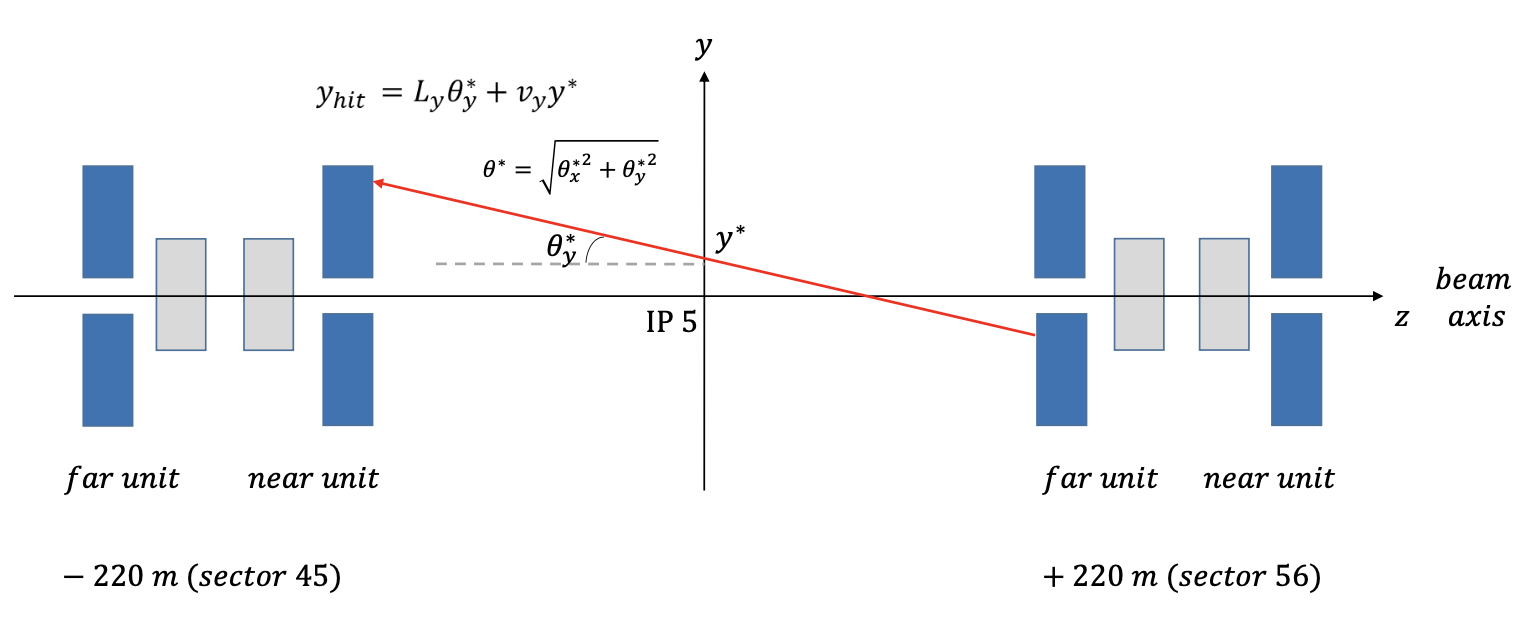

**Figure 16.** Side view of pp elastic scattering.

In beam optics, the transverse motion of a particle in an accelerator is governed by **Hill’s differential equation**:
$$\frac{d^2 u}{ds^2} + K(s) \cdot u = 0$$
where:
- $u$: x or y: transverse displacement (horizontal or vertical),
- $s$: path length along the beam,
- $K(s)$ = focusing strength, determined by magnetic fields.
It's general solution can be written as:
$$u(s) = \sqrt{\varepsilon \cdot \beta(s)} \cdot \cos(\psi(s) + \phi_0)$$
where:
- $ε$: emittance,
- $β(s)$: beta function (beam size),
- $ψ(s)$: phase advance,
- $\phi_0$: initial phase
​	
From this solution, one can derive the beam transport equation that relates the particle’s position and angle at the Interaction Point (IP) to its coordinates at the Roman Pot (RP) detector using the transport matrix:
$$
\begin{pmatrix}
u \\
\theta_u
\end{pmatrix}_{\text{RP}}
=
\begin{pmatrix}
v_u & L_u \\
a_u & b_u
\end{pmatrix}
\cdot
\begin{pmatrix}
u^* \\
\theta_u^*
\end{pmatrix}_{\text{IP}}
$$

Focusing only first row: 
$$
u = v_u \cdot u^* + L_u \cdot \theta_u^*
$$
- $u$: transverse displacement measured at the detector,
- $u^*$: transverse (vertex) position at the IP (typically close to 0 for elastic scattering),
- $θ_u^*$: scattering angle at the IP,
- $v_u$: magnification term (dimensionless),
- $L_u$: effective length (units of m), gives how much angle contributes to displacement.

This form is essential to determine the effective length $L_u$ , which plays a crucial role in reconstructing scattering angles from measured displacements. The $L_u$ and $v_u$ have the form of:
$$
L_u = \sqrt{\beta_u \cdot \beta^*} \cdot \sin(\Delta \psi_u)
$$
$$
v_u = \sqrt{\frac{\beta_u}{\beta^*}} \cdot \cos(\Delta \psi_u)
$$
where:
- $β^*$: beta function at the IP,
- $β_u$: beta function at the detector location,
- $Δψ_u$: betatron phase advance from IP to detector.

### Special Case in TOTEM

At the TOTEM experiment, a special beam optics configuration with a large $\beta^*$ value of 90 meters was chosen. This design serves two main purposes that are critical for precise elastic proton-proton scattering measurements:

1. **Accessing Small Scattering Angles:**

   The four-momentum transfer squared is related to the scattering angle $\theta^*$ by:
   $$|t| \approx \left( p \cdot \theta^* \right)^2$$

   To access small $|t|$ values —such as $|t| \approx 0.01 \,\ \text{GeV}^2$ which corresponds to $\theta^* \approx 29 \,\ \mu\text{rad}$ at $\sqrt{s} = 7 \,\ \text{TeV}$— the beam divergence must be on the order of a few microradians. Beam divergence is given by:
   $$\sigma_{\theta} = \sqrt{ \frac{\varepsilon}{\beta^*} }$$

   * Beam divergence refers to the angular spread of particles within a beam, how much the individual particles deviate from the nominal beam direction. Smaller $\sigma_{\theta}$ means particles are more parallel to each other and larger means particles are more spread in angle — the beam is more divergent.

   By increasing $\beta^*$, the beam divergence is reduced, allowing the experiment to observe very small scattering angles.

2. **Maximizing Sensitivity to $\theta_y^*$ and Minimizing Vertex Dependence:**   
   
   In beam optics, we know that the position $y$ at the Roman Pots given by the equation:
   $$y = v_y \cdot y^* + L_y \cdot \theta_y^*$$

   Since TOTEM configured the optics such that the phase advance $\Delta \psi_y = 90^\circ$. This choice ensures:
   * $v_y = 0$ (the vertex position contribution vanishes),
   * $L_y$ is maximized (for far stations $L_y$ = 260m and for near stations $L_y$ = 240m).

   This simplifies the equation to:
   $$y = L_y \cdot \theta_y^*$$
   which implies:
   * The measurement of $\theta_y^*$ becomes independent of the vertex position $y^*$,
   * The angle $\theta_y^*$ can be directly extracted from the track position $y$,
   * The measurement precision improves significantly.

On the other hand, horizontal scattering angle $\theta_x^*$ is reconstructed indirectly, due to the optics configuration where $L_x$ is set close to zero. This allows better sensitivity to the vertex position $x^*$ and enables $\theta_x^*$ reconstruction from combined measurements. The general equation in the horizontal plane is: 
$$x = v_x \cdot x^* + L_x \cdot \theta_x^*$$

   Optical configuration sets the phase advance $\Delta\psi_x$ close to 180°, which has the following key effects:
   * It minimizes $L_x \approx 0$ (for near stations 2.9m and farstations nearly 0m), making $x$ almost purely dependent on $x^*$.
   * It maximizes $\frac{dL_x}{ds}$, allowing $\theta_x^*$ to be extracted from angular measurements (track slopes) rather than direct position.

By choosing $L_x \approx 0$, the equation simplifies to:
$$x \approx v_x \cdot x^*$$
This implies that the $x$ measurement at the RP is almost entirely dependent on the vertex position $x^*$, not on the scattering angle $\theta_x^*$. This is beneficial because it allows one to accurately reconstruct **vertex position**, and separately extract **$\theta_x^*$** by comparing the near and far RP detectors.

**As a result, the optimal scattering-angle formula differ for two projections** [[3]](https://cds.cern.ch/record/1383030/files/0295-5075_96_2_21002.pdf):
* For $\theta_y^*$:
$$\theta_y^* = \frac{y}{L_y}$$

* And for $\theta_x^*$:
$$\theta_x^* = \frac{1}{L_x} \left( x - v_x \cdot x^* \right)$$
However, $v_x$ and $L_x$ are not constants — they vary along the beam path $s$. Therefore, to account for the transport behavior more precisely, we consider derivatives with respect to $s$ (path length). The more general form becomes:
$$\theta_x^* = \frac{1}{\frac{dL_x}{ds}} \left( \theta_x - \frac{dv_x}{ds} \cdot x^* \right)$$
where: 
* $\theta_x$: track angle at the detector (i.e. $\frac{dx}{ds}$)

In the raw dataset, hit measurements from Roman Pot detectors are only meaningful if the corresponding track has been successfully reconstructed. This validity is indicated by Boolean flags such as `track_rp_124_valid`. For events where the track is not reconstructed, the corresponding position **(track_rp_*_x**, **track_rp_*_y)** may either be recorded as 0 or NaN. These entries do not reflect true physical measurements and must be filtered out.

To correctly reconstruct the scattering angle, especially quantities like the vertical angle, only valid events must be used:

In [34]:
import pandas as pd

subset = dataset.AsNumpy(["track_rp_24_valid", "track_rp_24_y"])
df_y = pd.DataFrame(subset)

thy_data = dataset.AsNumpy(["th_y"])
df_thy = pd.DataFrame(thy_data)

print(df_y.head(10))
print(df_thy.head(10))

  track_rp_24_valid  track_rp_24_y
0              True       9.458460
1             False       0.000000
2              True       7.226854
3             False       0.000000
4              True      27.667666
5             False       0.000000
6             False       0.000000
7             False       0.000000
8              True       9.539058
9             False       0.000000
       th_y
0       NaN
1  0.000062
2  0.000047
3 -0.000030
4  0.000065
5  0.000056
6 -0.000062
7 -0.000020
8       NaN
9       NaN


Next, we compute the $L_y$ values for each RP station and evaluate their consistency with the expected values. 
* $L_y$ = 240m (near)
* $L_y$ = 260m (far)

In [35]:
rp_list = [
    ("RP 121", "track_rp_121_y", "track_rp_121_valid"),
    ("RP 125", "track_rp_125_y", "track_rp_125_valid"),
    ("RP 20", "track_rp_20_y",  "track_rp_20_valid"),
    ("RP 24", "track_rp_24_y",  "track_rp_24_valid")]

for rp_name, y_branch, valid_branch in rp_list:
    data_np = dataset.AsNumpy([valid_branch, y_branch, "th_y"])
    df = pd.DataFrame(data_np)

    df_clean = df[(df[valid_branch]) & (df[y_branch] != 0) & (df["th_y"].notna())]

    g = ROOT.TGraph()
    for i, (theta_y, y_val) in enumerate(zip(df_clean["th_y"], df_clean[y_branch])):
        y_m = y_val * 1e-3 
        g.SetPoint(i, theta_y, y_m)

    fit_func = ROOT.TF1("fit_func", "[0]*x", -0.0005, 0.0005)
    g.Fit(fit_func, "Q0") 

    L_y = fit_func.GetParameter(0)
    L_y_err = fit_func.GetParError(0)
    print(f"{rp_name}: L_y = {L_y:.2f} ± {L_y_err:.2f} m")

RP 121: L_y = -228.60 ± 0.25 m
RP 125: L_y = -253.38 ± 0.28 m
RP 20: L_y = 235.61 ± 0.19 m
RP 24: L_y = 260.54 ± 0.21 m


In [36]:
rp_list = [
    ("RP 120", "track_rp_120_y", "track_rp_120_valid"),
    ("RP 124", "track_rp_124_y", "track_rp_124_valid"),
    ("RP 021", "track_rp_21_y",  "track_rp_21_valid"),
    ("RP 025", "track_rp_25_y",  "track_rp_25_valid")]

for rp_name, y_branch, valid_branch in rp_list:
    data_np = dataset.AsNumpy([valid_branch, y_branch, "th_y"])
    df = pd.DataFrame(data_np)

    df_clean = df[(df[valid_branch]) & (df[y_branch] != 0) & (df["th_y"].notna())]

    g = ROOT.TGraph()
    for i, (theta_y, y_val) in enumerate(zip(df_clean["th_y"], df_clean[y_branch])):
        y_m = y_val * 1e-3 
        g.SetPoint(i, theta_y, y_m)

    fit_func = ROOT.TF1("fit_func", "[0]*x", -0.0005, 0.0005)
    g.Fit(fit_func, "Q0")  

    L_y = fit_func.GetParameter(0)
    L_y_err = fit_func.GetParError(0)
    print(f"{rp_name}: L_y = {L_y:.2f} ± {L_y_err:.2f} m")

RP 120: L_y = -214.72 ± 0.35 m
RP 124: L_y = -238.62 ± 0.38 m
RP 021: L_y = 236.33 ± 0.18 m
RP 025: L_y = 261.56 ± 0.20 m


To validate the equation: 
$$y = L_y \cdot \theta_y^*$$
A 2D histogram of the reconstructed scattering angle versus $\theta_y^*$ the hit position $y$ for each RP station. If the beam optics are properly configured, the relationship between 
$y$ and $θ_y^*$ should be linear, and the slope of this distribution corresponds to the effective length $L_y$.

In [37]:
data_np = dataset.AsNumpy(["track_rp_24_valid", "track_rp_24_y", "th_y"])
df = pd.DataFrame(data_np)

df_clean = df[
    (df["track_rp_24_valid"]) &
    (df["track_rp_24_y"] != 0) &
    (df["th_y"].notna())]

nbins_x = 200
nbins_y = 200
y_min_mm = -30
y_max_mm =  30
theta_y_min_murad = -200 
theta_y_max_murad =  200

hist = ROOT.TH2D("h", "RP 024 : #theta_{y}^{*} vs y; y [mm]; #theta_{y}^{*} [#mu rad]",
               nbins_x, y_min_mm, y_max_mm,
               nbins_y, theta_y_min_murad, theta_y_max_murad)

for theta_y, y_mm in zip(df_clean["th_y"], df_clean["track_rp_24_y"]):
    theta_y_murad = theta_y * 1e6  
    hist.Fill(y_mm, theta_y_murad)

canvas = ROOT.TCanvas("theta_vs_y", "RP 024: theta_y* vs y", 800, 600)
ROOT.gStyle.SetPalette()
ROOT.gPad.SetGrid()

hist.SetStats(0)
hist.Draw("colz")
canvas.Draw()


**Figure 17.** The sparse band in the lower half of the plot does not follow the main linear trend. This is likely due to:
* Background contamination, such as non-elastic or misreconstructed events.
* Beam halo, which causes hits at large angles unrelated to the main elastic scattering process.
* Detector inefficiencies or noise.

In beam optics, effective length $L_y$ and geometrical distance between the interaction point (IP) and a RP station are fundamentally different quantities: 
* Geometrical distance is simply the straight-line spatial separation between the IP and the detector (e.g. 220m).
* Effective Length $L_y$, on the other hand, arises from the beam transport matrix and incorporates the effects of magnetic optics. It quantifies how a scattering angle is translated into a position.
​	
Using the geometrical distance in place of $L_y$ to reconstruct $θ_y^*$ leads to systematic errors, because it ignores the actual beam focusing and phase advance determined by the optics configuration.

In the code below reconstructed $θ_y^*$ from the both effective length and geometric distance is compared.

In [38]:
L_y = 260.0      
z_pos = 220.0     

columns = ["track_rp_24_valid", "track_rp_24_y", "th_y"]
data = dataset.AsNumpy(columns)
df = pd.DataFrame(data)

df_valid = df[df["track_rp_24_valid"] & (df["track_rp_24_y"] != 0) & df["th_y"].notna()].copy()
df_valid["y_m"] = df_valid["track_rp_24_y"] * 1e-3  

df_valid["theta_y_L"] = df_valid["y_m"] / L_y       
df_valid["theta_y_z"] = df_valid["y_m"] / z_pos    
df_valid["theta_y_real"] = df_valid["th_y"]            

for i, row in df_valid.head(5).iterrows():
    print(f"Event {i}:")
    print(f" y = {row['y_m']:.5f} m")
    print(f" θ_y (from L_y) = {row['theta_y_L']:.5e} rad")
    print(f" θ_y (from z) = {row['theta_y_z']:.5e} rad")
    print(f" θ_y (real) = {row['theta_y_real']:.5e} rad")

Event 0:
 y = 0.01039 m
 θ_y (from L_y) = 3.99528e-05 rad
 θ_y (from z) = 4.72169e-05 rad
 θ_y (real) = 4.41876e-05 rad
Event 7:
 y = 0.01205 m
 θ_y (from L_y) = 4.63632e-05 rad
 θ_y (from z) = 5.47929e-05 rad
 θ_y (real) = 4.59009e-05 rad
Event 8:
 y = 0.00716 m
 θ_y (from L_y) = 2.75258e-05 rad
 θ_y (from z) = 3.25305e-05 rad
 θ_y (real) = 2.64517e-05 rad
Event 9:
 y = 0.01294 m
 θ_y (from L_y) = 4.97507e-05 rad
 θ_y (from z) = 5.87962e-05 rad
 θ_y (real) = 4.88733e-05 rad
Event 12:
 y = 0.00595 m
 θ_y (from L_y) = 2.28879e-05 rad
 θ_y (from z) = 2.70493e-05 rad
 θ_y (real) = 2.09136e-05 rad


## Saving NTuple file with elastic candidates

By selecting elastic candidates we reduce number of events from 12'606'699 to 1'588'513. In addition we defined new columns denoting in which diagonal the cadidate was selected.
Such files are more suitable for further analysis steps, due to reduced size on disk.
Different datasets require different conditions (i.e. detector alignment), therefore its processing is easier.

In [39]:
column_names_to_save = dataset1_diagonal.GetColumnNames()

dataset1_output_path = Path("dataset1_diagonals.root")
dataset1_diagonal.Snapshot("TotemNtuple", dataset1_output_path.as_posix(), column_names_to_save)


dataset2_output_path = Path("dataset2_diagonals.root")
dataset2_diagonal.Snapshot("TotemNtuple", dataset2_output_path.as_posix(), column_names_to_save)


dataset3_output_path = Path("dataset3_diagonals.root")
dataset3_diagonal.Snapshot("TotemNtuple", dataset3_output_path.as_posix(), column_names_to_save)

<cppyy.gbl.ROOT.RDF.RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0x34abcacc0>